Esse Notebook será dedicado a experimentar como os modelos classicos aprendem com os dados youtube e spotify.

* Primeiro será feito um teste com os modelos sem nenhum ajuste previo para entender como tão prevendo os dados em primeiro momento.

* Em segundo momento será testado como a idade dos dados ta afetenado previsão do modelo em 3 diferentes faixas de tempo.

* Retirar os outliers e ver como o modelo padrão de menor erro se comporta

possiveis melhorias:
*   tirar os outliers de engajamento
*   utilizar tecnicas como SMOTE para aumentar o numero de musicas com ate 30 dias
*   tirar outliers

Descobertas:
* Utilizar apenas musicas recentes não garante que vamos ter resultados melhores, portanto pode usar todas as musicas
* Musicas com mais dias são mais faceis de prever
* Retirar os outliers não trouxe grande melhoria
* Conforme vai ficando maior a idade dos videos mais preciso fica a regressão
* Se retirar os outliers do conjunto de treinamento o numero de streams ajuda na predição

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from sklearn.linear_model import  LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
import xgboost as xgb

In [3]:
# ruff: noqa: E402
import math
import warnings
from typing import Dict, Literal

warnings.simplefilter("ignore")
import delu  # Deep Learning Utilities: https://github.com/Yura52/delu
import numpy as np
import scipy.special
import sklearn.datasets
import sklearn.metrics
import sklearn.model_selection
import sklearn.preprocessing
import torch
import torch.nn.functional as F
import torch.optim
from torch import Tensor
from tqdm.std import tqdm

warnings.resetwarnings()

from rtdl_revisiting_models import MLP, ResNet, FTTransformer

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Set random seeds in all libraries.
delu.random.seed(0)

0

# Tratamento dos dados

In [5]:
spotify_youtube_pt1 = pd.read_csv("Dados/spotify_youtube_up_pt1.csv")
spotify_youtube_pt2 = pd.read_csv("Dados/spotify_youtube_up_pt2.csv")

In [6]:
data_extracao = pd.to_datetime("2023-02-07")
spotify_youtube_pt1["upload_date"] = pd.to_datetime(spotify_youtube_pt1["upload_date"])
spotify_youtube_pt1["dias_na_plataforma"] = (data_extracao - spotify_youtube_pt1["upload_date"]).dt.days

spotify_youtube_pt2["upload_date"] = pd.to_datetime(spotify_youtube_pt2["upload_date"])
spotify_youtube_pt2["dias_na_plataforma"] = (data_extracao - spotify_youtube_pt2["upload_date"]).dt.days

In [7]:
spotify_youtube = pd.concat([spotify_youtube_pt1,spotify_youtube_pt2])

In [8]:
spotify_youtube_dummies= pd.get_dummies(spotify_youtube,columns=['Album_type'], dtype=int)

In [9]:
spotify_youtube_dummies['artist_number'] = spotify_youtube_dummies['Artist'].str.split(',').str.len()
spotify_youtube_dummies['engagement_rate'] = spotify_youtube_dummies.apply(lambda row: (row['Likes'] + row['Comments']) / row['Views'] * 100 if row['Views'] > 0 else 0, axis=1)

In [10]:
columns_drop=['Unnamed: 0', 'Artist', 'Url_spotify', 'Track', 'Album', 'Uri','Url_youtube', 'Title', 'Channel', 'Views', 'Likes','Comments', 'Description', 'Licensed', 'official_video', 'upload_date','Stream']
spotify_youtube_df=spotify_youtube_dummies.drop(columns=columns_drop)

In [11]:
spotify_youtube_limpo=spotify_youtube_df.dropna(subset=['Danceability','Energy','Key','Loudness','Speechiness','Acousticness', 'Instrumentalness','Liveness','Valence','Tempo','Duration_ms','engagement_rate'])

# Preparação dos dados para os experimentos

In [12]:
youtube_30_df=spotify_youtube_limpo[spotify_youtube_limpo['dias_na_plataforma']<31]
youtube_90_df=spotify_youtube_limpo[spotify_youtube_limpo['dias_na_plataforma']<91]
youtube_365_df=spotify_youtube_limpo[spotify_youtube_limpo['dias_na_plataforma']<366]

In [13]:
spotify_youtube_df_366_more = spotify_youtube_limpo.drop(youtube_365_df.index)
spotify_youtube_df_91_365 = youtube_365_df.drop(youtube_90_df.index)
spotify_youtube_df_31_90 = youtube_365_df.drop(youtube_30_df.index)

Total number of outliers in column engagement_rate: 592
Lower limit: -0.4855731167119207, Upper limit: 2.251193229196198
-----------------------------------------------------------


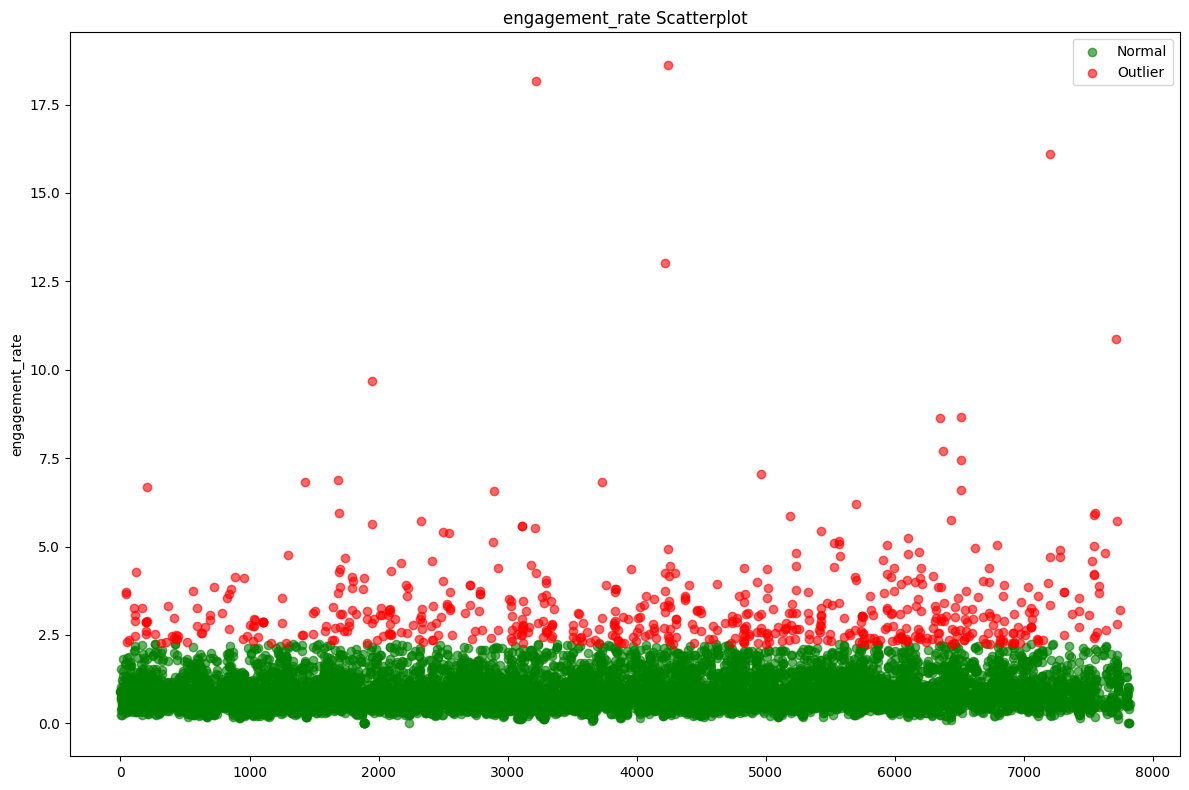

In [14]:
def find_outliers_iqr(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers = data[(data[column] < lower_bound) | (data[column] > upper_bound)]
    return outliers, lower_bound, upper_bound


columns_to_check = ["engagement_rate"]


plt.figure(figsize = (12, 8))
for i, col in enumerate(columns_to_check, 1):

    outliers, lower, upper = find_outliers_iqr(spotify_youtube_df_366_more, col)

   
    normal_values = spotify_youtube_df_366_more[(spotify_youtube_df_366_more[col] >= lower) & (spotify_youtube_df_366_more[col] <= upper)]

    
    plt.subplot(1, 1, i)
    plt.scatter(normal_values.index, normal_values[col], label = "Normal", alpha = 0.6, c = "green")
    plt.scatter(outliers.index, outliers[col], label = "Outlier", alpha=0.6, c = "red")
    plt.title(f"{col} Scatterplot")
    plt.ylabel(col)
    plt.legend()

    
    print(f"Total number of outliers in column {col}: {len(outliers)}")
    print(f"Lower limit: {lower}, Upper limit: {upper}")
    print("-" * 59)

plt.tight_layout()
plt.show()

In [15]:
youtube_30_df=youtube_30_df[youtube_30_df['engagement_rate']<9.338507725109846]
spotify_youtube_df_31_90=spotify_youtube_df_31_90[spotify_youtube_df_31_90['engagement_rate']<4.602401258613792]
spotify_youtube_df_91_365=spotify_youtube_df_91_365[spotify_youtube_df_91_365['engagement_rate']<4.253191569584401]
spotify_youtube_df_366_more=spotify_youtube_df_366_more[spotify_youtube_df_366_more['engagement_rate']<2.251193229196198]

In [16]:
youtube_30_df_x = youtube_30_df.drop('engagement_rate',axis=1)
youtube_30_df_y = youtube_30_df['engagement_rate']

spotify_youtube_df_31_90_x = spotify_youtube_df_31_90.drop('engagement_rate',axis=1)
spotify_youtube_df_31_90_y = spotify_youtube_df_31_90['engagement_rate']

spotify_youtube_df_91_365_x = spotify_youtube_df_91_365.drop('engagement_rate',axis=1)
spotify_youtube_df_91_365_y = spotify_youtube_df_91_365['engagement_rate']

spotify_youtube_df_366_more_x = spotify_youtube_df_366_more.drop('engagement_rate',axis=1)
spotify_youtube_df_366_more_y = spotify_youtube_df_366_more['engagement_rate']

In [17]:
spotify_youtube_30X_train_val, spotify_youtube_30X_test, spotify_youtube_30y_train_val, spotify_youtube_30y_test = train_test_split(youtube_30_df_x, youtube_30_df_y, test_size=0.25, random_state=42)
spotify_youtube_30X_train, spotify_youtube_30X_val, spotify_youtube_30y_train, spotify_youtube_30y_val = train_test_split(spotify_youtube_30X_train_val, spotify_youtube_30y_train_val, test_size=0.20, random_state=42)
spotify_youtube_df_31_90X_train, spotify_youtube_df_31_90X_test, spotify_youtube_df_31_90y_train, spotify_youtube_df_31_90y_test = train_test_split(spotify_youtube_df_31_90_x, spotify_youtube_df_31_90_y, test_size=0.25, random_state=42)
spotify_youtube_df_91_365X_train, spotify_youtube_df_91_365X_test, spotify_youtube_df_91_365y_train, spotify_youtube_df_91_365y_test = train_test_split(spotify_youtube_df_91_365_x, spotify_youtube_df_91_365_y, test_size=0.25, random_state=42)

In [18]:
# Dados de treino 
sy_x_train=pd.concat([spotify_youtube_30X_train,spotify_youtube_df_31_90X_train,spotify_youtube_df_91_365X_train,spotify_youtube_df_366_more_x])
sy_y_train=pd.concat([spotify_youtube_30y_train,spotify_youtube_df_31_90y_train,spotify_youtube_df_91_365y_train,spotify_youtube_df_366_more_y])

In [19]:
sy_90_x_train=pd.concat([spotify_youtube_30X_train,spotify_youtube_df_31_90X_train])
sy_90_y_train=pd.concat([spotify_youtube_30y_train,spotify_youtube_df_31_90y_train])

In [20]:
sy_365_x_train=pd.concat([spotify_youtube_30X_train,spotify_youtube_df_31_90X_train,spotify_youtube_df_91_365X_train])
sy_365_y_train=pd.concat([spotify_youtube_30y_train,spotify_youtube_df_31_90y_train,spotify_youtube_df_91_365y_train])

In [21]:
sy_30_x_val=spotify_youtube_30X_val
sy_30_y_val=spotify_youtube_30y_val

In [22]:
# Para testar o desempenho do modelo com videos com ate 30 dias
sy_30_x_test=spotify_youtube_30X_test
sy_30_y_test=spotify_youtube_30y_test

# Para testar o desempenho do modelo com videos com ate 90 dias
sy_90_x_test=pd.concat([spotify_youtube_30X_test,spotify_youtube_df_31_90X_test])
sy_90_y_test=pd.concat([spotify_youtube_30y_test,spotify_youtube_df_31_90y_test])

# Para testar o desempenho do modelo com videos com ate 1 ano
sy_365_x_test=pd.concat([spotify_youtube_30X_test,spotify_youtube_df_31_90X_test,spotify_youtube_df_91_365X_test])
sy_365_y_test=pd.concat([spotify_youtube_30y_test,spotify_youtube_df_31_90y_test,spotify_youtube_df_91_365y_test])

# Transformers

In [35]:
class YNormalizer:
    def __init__(self):
        self.mean_ = None
        self.std_ = None

    def fit(self, y):
        """Calcula a média e o desvio padrão."""
        self.mean_ = y.mean().item()
        self.std_ = y.std().item()

    def transform(self, y):
        """Normaliza os dados."""
        if self.mean_ is None or self.std_ is None:
            raise RuntimeError("Você precisa chamar 'fit' antes de 'transform'.")
        return (y - self.mean_) / self.std_

    def inverse_transform(self, y_normalized):
        """Volta para a escala original."""
        if self.mean_ is None or self.std_ is None:
            raise RuntimeError("Você precisa chamar 'fit' antes de 'inverse_transform'.")
        return y_normalized * self.std_ + self.mean_

In [36]:
TaskType = Literal["regression", "binclass", "multiclass"]

task_type: TaskType = "regression"
n_classes = None
dataset = "youtube_30"
X_cont: np.ndarray = youtube_30_df_x.values
Y: np.ndarray = youtube_30_df_y.values

# NOTE: uncomment to solve a classification task.
# n_classes = 2
# assert n_classes >= 2
# task_type: TaskType = 'binclass' if n_classes == 2 else 'multiclass'
# X_cont, Y = sklearn.datasets.make_classification(
#     n_samples=20000,
#     n_features=8,
#     n_classes=n_classes,
#     n_informative=3,
#     n_redundant=2,
# )

# >>> Continuous features.
X_cont: np.ndarray = X_cont.astype(np.float32)
n_cont_features = X_cont.shape[1]

# >>> Categorical features.
# NOTE: the above datasets do not have categorical features, but,
# for the demonstration purposes, it is possible to generate them.
cat_cardinalities = [
    # NOTE: uncomment the two lines below to add two categorical features.
    # 4,  # Allowed values: [0, 1, 2, 3].
    # 7,  # Allowed values: [0, 1, 2, 3, 4, 5, 6].
]
X_cat = (
    np.column_stack(
        [np.random.randint(0, c, (len(X_cont),)) for c in cat_cardinalities]
    )
    if cat_cardinalities
    else None
)

# >>> Labels.
# Regression labels must be represented by float32.
if task_type == "regression":
    Y = Y.astype(np.float32)
else:
    assert n_classes is not None
    Y = Y.astype(np.int64)
    assert set(Y.tolist()) == set(
        range(n_classes)
    ), "Classification labels must form the range [0, 1, ..., n_classes - 1]"

# >>> Split the dataset.
all_idx = np.arange(len(Y))
trainval_idx, test_idx = sklearn.model_selection.train_test_split(
    all_idx, train_size=0.8
)
train_idx, val_idx = sklearn.model_selection.train_test_split(
    trainval_idx, train_size=0.8
)
data_numpy = {
    "train": {"x_cont": X_cont[train_idx], "y": Y[train_idx]},
    "val": {"x_cont": X_cont[val_idx], "y": Y[val_idx]},
    "test": {"x_cont": X_cont[test_idx], "y": Y[test_idx]},
}
if X_cat is not None:
    data_numpy["train"]["x_cat"] = X_cat[train_idx]
    data_numpy["val"]["x_cat"] = X_cat[val_idx]
    data_numpy["test"]["x_cat"] = X_cat[test_idx]

In [37]:
# >>> Feature preprocessing.
# NOTE
# The choice between preprocessing strategies depends on a task and a model.

# (A) Simple preprocessing strategy.
# preprocessing = sklearn.preprocessing.StandardScaler().fit(
#     data_numpy['train']['x_cont']
# )

# (B) Fancy preprocessing strategy.
# The noise is added to improve the output of QuantileTransformer in some cases.
X_cont_train_numpy = data_numpy["train"]["x_cont"]
noise = (
    np.random.default_rng(0)
    .normal(0.0, 1e-5, X_cont_train_numpy.shape)
    .astype(X_cont_train_numpy.dtype)
)
preprocessing = sklearn.preprocessing.QuantileTransformer(
    n_quantiles=max(min(len(train_idx) // 30, 1000), 10),
    output_distribution="normal",
    subsample=10**9,
).fit(X_cont_train_numpy + noise)
del X_cont_train_numpy

for part in data_numpy:
    data_numpy[part]["x_cont"] = preprocessing.transform(data_numpy[part]["x_cont"])

normalizer = YNormalizer()

# >>> Label preprocessing.
if task_type == "regression":
    normalizer.fit(data_numpy["train"]["y"])

    for part in data_numpy:
        data_numpy[part]["y"] = normalizer.transform(data_numpy[part]["y"])

# >>> Convert data to tensors.
data = {
    part: {k: torch.as_tensor(v, device=device) for k, v in data_numpy[part].items()}
    for part in data_numpy
}

if task_type != "multiclass":
    # Required by F.binary_cross_entropy_with_logits
    for part in data:
        data[part]["y"] = data[part]["y"].float()

In [30]:
# >>> Ajustando os dados para os Transformers
TaskType = Literal["regression", "binclass", "multiclass"]

task_type: TaskType = "regression"
n_classes = None

# Convertendo os conjuntos de treino, validação e teste para arrays NumPy
X_cont_train = sy_x_train.values.astype(np.float32)
Y_train = sy_y_train.values.astype(np.float32)

X_cont_val = sy_30_x_val.values.astype(np.float32)
Y_val = sy_30_y_val.values.astype(np.float32)

X_cont_test = sy_30_x_test.values.astype(np.float32)
Y_test = sy_30_y_test.values.astype(np.float32)

n_cont_features = X_cont_train.shape[1]

# >>> Labels.
if task_type == "regression":
    Y_train = Y_train.astype(np.float32)
    Y_val = Y_val.astype(np.float32)
    Y_test = Y_test.astype(np.float32)
else:
    assert n_classes is not None
    Y_train = Y_train.astype(np.int64)
    Y_val = Y_val.astype(np.int64)
    Y_test = Y_test.astype(np.int64)

# >>> Preparando os dados para treino, validação e teste
data_numpy = {
    "train": {"x_cont": X_cont_train, "y": Y_train},
    "val": {"x_cont": X_cont_val, "y": Y_val},
    "test": {"x_cont": X_cont_test, "y": Y_test},
}

# >>> Pré-processamento das features contínuas
X_cont_train_numpy = data_numpy["train"]["x_cont"]
noise = (
    np.random.default_rng(0)
    .normal(0.0, 1e-5, X_cont_train_numpy.shape)
    .astype(X_cont_train_numpy.dtype)
)

preprocessing = sklearn.preprocessing.QuantileTransformer(
    n_quantiles=max(min(len(X_cont_train) // 30, 1000), 10),
    output_distribution="normal",
    subsample=10**9,
).fit(X_cont_train_numpy + noise)
del X_cont_train_numpy

for part in data_numpy:
    data_numpy[part]["x_cont"] = preprocessing.transform(data_numpy[part]["x_cont"])

normalizer = YNormalizer()

# >>> Pré-processamento dos labels
if task_type == "regression":
    normalizer.fit(data_numpy["train"]["y"])

    for part in data_numpy:
        data_numpy[part]["y"] = normalizer.transform(data_numpy[part]["y"])

# >>> Convertendo os dados para tensores
data = {
    part: {k: torch.as_tensor(v, device=device) for k, v in data_numpy[part].items()}
    for part in data_numpy
}

if task_type != "multiclass":
    # Requerido por F.binary_cross_entropy_with_logits
    for part in data:
        data[part]["y"] = data[part]["y"].float()

In [38]:
# The output size.
#cat_cardinalities = None
d_out = n_classes if task_type == "multiclass" else 1

model = FTTransformer(
    n_cont_features=n_cont_features,
    cat_cardinalities=cat_cardinalities,
    d_out=d_out,
    **FTTransformer.get_default_kwargs(),
).to(device)
optimizer = model.make_default_optimizer()

In [39]:
def apply_model(batch: Dict[str, Tensor]) -> Tensor:
    if isinstance(model, (MLP, ResNet)):
        x_cat_ohe = (
            [
                F.one_hot(column, cardinality)
                for column, cardinality in zip(batch["x_cat"].T, cat_cardinalities)
            ]
            if "x_cat" in batch
            else []
        )
        return model(torch.column_stack([batch["x_cont"]] + x_cat_ohe)).squeeze(-1)

    elif isinstance(model, FTTransformer):
        return model(batch["x_cont"], batch.get("x_cat")).squeeze(-1)

    else:
        raise RuntimeError(f"Unknown model type: {type(model)}")


loss_fn = (
    F.binary_cross_entropy_with_logits
    if task_type == "binclass"
    else F.cross_entropy
    if task_type == "multiclass"
    else F.mse_loss
)


@torch.no_grad()
def evaluate(part: str) -> float:
    model.eval()

    eval_batch_size = 8096
    y_pred = (
        torch.cat(
            [
                apply_model(batch)
                for batch in delu.iter_batches(data[part], eval_batch_size)
            ]
        )
        .cpu()
        .numpy()
    )
    y_true = data[part]["y"].cpu().numpy()

    if task_type == "binclass":
        y_pred = np.round(scipy.special.expit(y_pred))
        score = sklearn.metrics.accuracy_score(y_true, y_pred)
    elif task_type == "multiclass":
        y_pred = y_pred.argmax(1)
        score = sklearn.metrics.accuracy_score(y_true, y_pred)
    else:
        assert task_type == "regression"
        mse = sklearn.metrics.mean_squared_error(normalizer.inverse_transform(y_true), normalizer.inverse_transform(y_pred))
        score = -(sklearn.metrics.mean_squared_error(y_true, y_pred) ** 0.5 * normalizer.std_)
        #score = sklearn.metrics.mean_squared_error(y_true, y_pred)
    return score,mse  # The higher -- the better.

eval,_=evaluate("test")
print(f'Test score before training: {eval:.4f}')

Test score before training: -1.8014


In [40]:
# Apenas com dados de 30 dias
# For demonstration purposes (fast training and bad performance),
# one can set smaller values:
# n_epochs = 20
# patience = 2

n_epochs = 100
patience = 16

batch_size = 32
epoch_size = math.ceil(len(train_idx) / batch_size)
timer = delu.tools.Timer()

# MSE: queremos minimizar -> mode="min"
early_stopping = delu.tools.EarlyStopping(patience, mode="min")

best = {
    "val": -math.inf,
    "test": -math.inf,
    "mse": float("inf"),
    "epoch": -1,
}

print(f"Device: {device.type.upper()}")
print("-" * 88 + "\n")
timer.run()

for epoch in range(n_epochs):
    for batch in tqdm(
        delu.iter_batches(data["train"], batch_size, shuffle=True),
        desc=f"Epoch {epoch}",
        total=epoch_size,
    ):
        model.train()
        optimizer.zero_grad()
        loss = loss_fn(apply_model(batch), batch["y"])
        loss.backward()
        optimizer.step()

    val_score,_ = evaluate("val")
    test_score,test_mse = evaluate("test")
    print(f"(val) {val_score:.4f} (test) {test_score:.4f} (mse) {test_mse} [time] {timer}")

    early_stopping.update(val_score)
    if early_stopping.should_stop():
        break

    if val_score > best["val"]:
        print("🌸 New best epoch! 🌸")
        best = {"val": val_score, "test": test_score, "mse":test_mse, "epoch": epoch}
    print()

print("\n\nResult:")
print(best)

Device: CPU
----------------------------------------------------------------------------------------



Epoch 0: 100%|██████████| 7/7 [00:00<00:00, 28.00it/s]


(val) -2.0243 (test) -1.9150 (mse) 3.667229413986206 [time] 0:00:00.297763
🌸 New best epoch! 🌸



Epoch 1: 100%|██████████| 7/7 [00:00<00:00, 26.71it/s]


(val) -2.0703 (test) -1.8437 (mse) 3.399109363555908 [time] 0:00:00.611476



Epoch 2: 100%|██████████| 7/7 [00:00<00:00, 25.06it/s]


(val) -1.8984 (test) -1.7718 (mse) 3.1391549110412598 [time] 0:00:00.924391
🌸 New best epoch! 🌸



Epoch 3: 100%|██████████| 7/7 [00:00<00:00, 19.28it/s]


(val) -1.9768 (test) -1.8343 (mse) 3.364656448364258 [time] 0:00:01.328774



Epoch 4: 100%|██████████| 7/7 [00:00<00:00, 30.26it/s]


(val) -1.8624 (test) -1.8390 (mse) 3.3818411827087402 [time] 0:00:01.602589
🌸 New best epoch! 🌸



Epoch 5: 100%|██████████| 7/7 [00:00<00:00, 31.17it/s]


(val) -1.9844 (test) -1.9088 (mse) 3.64339280128479 [time] 0:00:01.868747



Epoch 6: 100%|██████████| 7/7 [00:00<00:00, 28.91it/s]


(val) -1.9108 (test) -1.8832 (mse) 3.5464024543762207 [time] 0:00:02.154549



Epoch 7: 100%|██████████| 7/7 [00:00<00:00, 31.37it/s]


(val) -2.1518 (test) -1.9806 (mse) 3.922633171081543 [time] 0:00:02.421891



Epoch 8: 100%|██████████| 7/7 [00:00<00:00, 30.57it/s]


(val) -1.9812 (test) -1.8143 (mse) 3.291703224182129 [time] 0:00:02.680682



Epoch 9: 100%|██████████| 7/7 [00:00<00:00, 35.37it/s]


(val) -2.1261 (test) -1.9639 (mse) 3.8568966388702393 [time] 0:00:02.927697



Epoch 10: 100%|██████████| 7/7 [00:00<00:00, 30.57it/s]


(val) -2.0237 (test) -1.9879 (mse) 3.9516398906707764 [time] 0:00:03.188574



Epoch 11: 100%|██████████| 7/7 [00:00<00:00, 21.44it/s]


(val) -2.1924 (test) -1.9463 (mse) 3.7881088256835938 [time] 0:00:03.555478



Epoch 12: 100%|██████████| 7/7 [00:00<00:00, 31.79it/s]


(val) -1.9622 (test) -1.7311 (mse) 2.9968113899230957 [time] 0:00:03.813834



Epoch 13: 100%|██████████| 7/7 [00:00<00:00, 32.58it/s]


(val) -2.0705 (test) -1.8719 (mse) 3.503870725631714 [time] 0:00:04.079782



Epoch 14: 100%|██████████| 7/7 [00:00<00:00, 31.33it/s]


(val) -2.0225 (test) -1.8681 (mse) 3.489859104156494 [time] 0:00:04.341551



Epoch 15: 100%|██████████| 7/7 [00:00<00:00, 27.40it/s]


(val) -1.9987 (test) -1.7217 (mse) 2.964120388031006 [time] 0:00:04.649565



Epoch 16: 100%|██████████| 7/7 [00:00<00:00, 28.84it/s]


(val) -2.0529 (test) -1.7634 (mse) 3.109616279602051 [time] 0:00:04.933457



Epoch 17: 100%|██████████| 7/7 [00:00<00:00, 31.12it/s]


(val) -1.9654 (test) -1.8464 (mse) 3.4090540409088135 [time] 0:00:05.199426



Epoch 18: 100%|██████████| 7/7 [00:00<00:00, 20.20it/s]


(val) -2.2657 (test) -1.9730 (mse) 3.892824649810791 [time] 0:00:05.584863



Epoch 19: 100%|██████████| 7/7 [00:00<00:00, 32.34it/s]


(val) -2.0372 (test) -1.7316 (mse) 2.998556137084961 [time] 0:00:05.846609



Epoch 20: 100%|██████████| 7/7 [00:00<00:00, 35.19it/s]


(val) -2.0465 (test) -1.8321 (mse) 3.3566699028015137 [time] 0:00:06.096169



Epoch 21: 100%|██████████| 7/7 [00:00<00:00, 30.57it/s]


(val) -2.0651 (test) -1.8476 (mse) 3.413588285446167 [time] 0:00:06.364091



Epoch 22: 100%|██████████| 7/7 [00:00<00:00, 25.28it/s]


(val) -2.2666 (test) -1.8638 (mse) 3.4735682010650635 [time] 0:00:06.682337



Epoch 23: 100%|██████████| 7/7 [00:00<00:00, 27.73it/s]


(val) -2.2153 (test) -1.8759 (mse) 3.518843650817871 [time] 0:00:06.977883



Epoch 24: 100%|██████████| 7/7 [00:00<00:00, 30.20it/s]


(val) -1.9465 (test) -1.8162 (mse) 3.2985522747039795 [time] 0:00:07.335389



Epoch 25: 100%|██████████| 7/7 [00:00<00:00, 33.35it/s]


(val) -2.0196 (test) -1.9034 (mse) 3.622795581817627 [time] 0:00:07.597089



Epoch 26: 100%|██████████| 7/7 [00:00<00:00, 32.38it/s]


(val) -1.9706 (test) -1.8327 (mse) 3.358680009841919 [time] 0:00:07.857384



Epoch 27: 100%|██████████| 7/7 [00:00<00:00, 25.75it/s]


(val) -2.0766 (test) -1.8676 (mse) 3.4877915382385254 [time] 0:00:08.190941



Epoch 28: 100%|██████████| 7/7 [00:00<00:00, 30.63it/s]


(val) -2.2046 (test) -1.8994 (mse) 3.6076061725616455 [time] 0:00:08.462071



Epoch 29: 100%|██████████| 7/7 [00:00<00:00, 30.75it/s]


(val) -2.2249 (test) -2.0002 (mse) 4.000626087188721 [time] 0:00:08.725983



Epoch 30: 100%|██████████| 7/7 [00:00<00:00, 30.05it/s]


(val) -2.1294 (test) -1.8967 (mse) 3.5974206924438477 [time] 0:00:08.998375



Epoch 31: 100%|██████████| 7/7 [00:00<00:00, 20.75it/s]


(val) -2.1763 (test) -1.9816 (mse) 3.9265594482421875 [time] 0:00:09.377653



Epoch 32: 100%|██████████| 7/7 [00:00<00:00, 30.00it/s]


(val) -2.1916 (test) -2.0070 (mse) 4.0281572341918945 [time] 0:00:09.646114



Epoch 33: 100%|██████████| 7/7 [00:00<00:00, 33.04it/s]


(val) -2.1595 (test) -2.0043 (mse) 4.017075061798096 [time] 0:00:09.898405



Epoch 34: 100%|██████████| 7/7 [00:00<00:00, 32.75it/s]


(val) -2.1053 (test) -1.9106 (mse) 3.6505661010742188 [time] 0:00:10.164620



Epoch 35: 100%|██████████| 7/7 [00:00<00:00, 32.75it/s]


(val) -2.1198 (test) -1.9647 (mse) 3.8602328300476074 [time] 0:00:10.415762



Epoch 36: 100%|██████████| 7/7 [00:00<00:00, 30.44it/s]


(val) -2.1749 (test) -2.0123 (mse) 4.049516677856445 [time] 0:00:10.681792



Epoch 37: 100%|██████████| 7/7 [00:00<00:00, 35.37it/s]


(val) -2.0533 (test) -1.9351 (mse) 3.744466781616211 [time] 0:00:10.931436



Epoch 38: 100%|██████████| 7/7 [00:00<00:00, 23.51it/s]


(val) -2.1174 (test) -2.0300 (mse) 4.120716094970703 [time] 0:00:11.277085


Result:
{'val': -1.8623957161649796, 'test': -1.8389783119656267, 'mse': 3.3818411827087402, 'epoch': 4}


In [34]:
# Configurações de treinamento
n_epochs = 100
patience = 16

batch_size = 32
epoch_size = math.ceil(len(data["train"]["x_cont"]) / batch_size)
timer = delu.tools.Timer()

# MSE: queremos minimizar -> mode="min"
early_stopping = delu.tools.EarlyStopping(patience, mode="min")

best = {
    "val": -math.inf,
    "test": -math.inf,
    "mse": float("inf"),
    "epoch": -1,
}

print(f"Device: {device.type.upper()}")
print("-" * 88 + "\n")
timer.run()

for epoch in range(n_epochs):
    for batch in tqdm(
        delu.iter_batches(data["train"], batch_size, shuffle=True),
        desc=f"Epoch {epoch}",
        total=epoch_size,
    ):
        model.train()
        optimizer.zero_grad()
        loss = loss_fn(apply_model(batch), batch["y"])
        loss.backward()
        optimizer.step()

    val_score, _ = evaluate("val")
    test_score, test_mse = evaluate("test")
    print(f"(val) {val_score:.4f} (test) {test_score:.4f} (mse) {test_mse} [time] {timer}")

    early_stopping.update(val_score)
    if early_stopping.should_stop():
        break

    if val_score > best["val"]:
        print("🌸 New best epoch! 🌸")
        best = {"val": val_score, "test": test_score, "mse": test_mse, "epoch": epoch}
    print()

print("\n\nResult:")
print(best)

Device: CPU
----------------------------------------------------------------------------------------



Epoch 0: 100%|██████████| 398/398 [00:14<00:00, 28.28it/s]


(val) -2.0857 (test) -2.0726 (mse) 4.295776844024658 [time] 0:00:14.119950
🌸 New best epoch! 🌸



Epoch 1: 100%|██████████| 398/398 [00:13<00:00, 29.88it/s]


(val) -2.0949 (test) -2.1249 (mse) 4.5150146484375 [time] 0:00:27.494134



Epoch 2: 100%|██████████| 398/398 [00:15<00:00, 26.49it/s]


(val) -2.0881 (test) -1.9985 (mse) 3.994184970855713 [time] 0:00:42.561022



Epoch 3: 100%|██████████| 398/398 [00:13<00:00, 28.99it/s]


(val) -2.1566 (test) -2.1496 (mse) 4.620800971984863 [time] 0:00:56.344392



Epoch 4: 100%|██████████| 398/398 [00:13<00:00, 30.22it/s]


(val) -2.2646 (test) -2.1647 (mse) 4.685763359069824 [time] 0:01:09.555295



Epoch 5: 100%|██████████| 398/398 [00:13<00:00, 29.25it/s]


(val) -2.1991 (test) -2.1268 (mse) 4.523179054260254 [time] 0:01:23.205896



Epoch 6: 100%|██████████| 398/398 [00:14<00:00, 28.33it/s]


(val) -2.0422 (test) -1.9927 (mse) 3.9710395336151123 [time] 0:01:37.307510
🌸 New best epoch! 🌸



Epoch 7: 100%|██████████| 398/398 [00:13<00:00, 29.19it/s]


(val) -1.9992 (test) -1.9699 (mse) 3.880493640899658 [time] 0:01:50.986050
🌸 New best epoch! 🌸



Epoch 8: 100%|██████████| 398/398 [00:13<00:00, 29.30it/s]


(val) -2.1013 (test) -2.0092 (mse) 4.0370001792907715 [time] 0:02:04.614896



Epoch 9: 100%|██████████| 398/398 [00:13<00:00, 28.89it/s]


(val) -2.0673 (test) -1.9832 (mse) 3.9329521656036377 [time] 0:02:18.433366



Epoch 10: 100%|██████████| 398/398 [00:13<00:00, 29.02it/s]


(val) -2.0906 (test) -2.0542 (mse) 4.219779968261719 [time] 0:02:32.191392



Epoch 11: 100%|██████████| 398/398 [00:13<00:00, 29.27it/s]


(val) -2.0048 (test) -1.9578 (mse) 3.8330910205841064 [time] 0:02:45.831743



Epoch 12: 100%|██████████| 398/398 [00:13<00:00, 30.01it/s]


(val) -2.1286 (test) -2.0702 (mse) 4.285667896270752 [time] 0:02:59.138260



Epoch 13: 100%|██████████| 398/398 [00:13<00:00, 28.89it/s]


(val) -2.0402 (test) -2.0755 (mse) 4.307807445526123 [time] 0:03:12.963062



Epoch 14: 100%|██████████| 398/398 [00:13<00:00, 30.11it/s]


(val) -2.0070 (test) -2.0051 (mse) 4.020299911499023 [time] 0:03:26.222430



Epoch 15: 100%|██████████| 398/398 [00:13<00:00, 29.97it/s]


(val) -1.9744 (test) -1.9799 (mse) 3.9201724529266357 [time] 0:03:39.546462
🌸 New best epoch! 🌸



Epoch 16: 100%|██████████| 398/398 [00:13<00:00, 29.75it/s]


(val) -2.0529 (test) -2.1335 (mse) 4.551864147186279 [time] 0:03:52.980497



Epoch 17: 100%|██████████| 398/398 [00:13<00:00, 29.41it/s]


(val) -2.0502 (test) -2.0004 (mse) 4.001648902893066 [time] 0:04:06.555527



Epoch 18: 100%|██████████| 398/398 [00:13<00:00, 29.67it/s]


(val) -2.0099 (test) -2.0190 (mse) 4.076539516448975 [time] 0:04:20.004446



Epoch 19: 100%|██████████| 398/398 [00:13<00:00, 30.09it/s]


(val) -2.0383 (test) -1.9841 (mse) 3.936525344848633 [time] 0:04:33.281352



Epoch 20: 100%|██████████| 398/398 [00:13<00:00, 30.26it/s]

(val) -2.1177 (test) -2.1289 (mse) 4.532148361206055 [time] 0:04:46.475413


Result:
{'val': -1.9743982608848545, 'test': -1.9799427175624165, 'mse': 3.9201724529266357, 'epoch': 15}
